In [ ]:
!pip install transformers

In [1]:
import numpy as np
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import glob
from sklearn.metrics import confusion_matrix
import IPython.display as ipd # to play audio in the notebook
import sys
import warnings
from sklearn.model_selection import train_test_split

import pywt
import matplotlib.pyplot as plt
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import cv2
from scipy.io import wavfile

from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer

from PIL import Image
import torch.optim as optim

In [2]:
TESS = '/content/drive/MyDrive/Colab Notebooks/Dataset/TESS/'
print(os.listdir(TESS))

['YAF_sad', 'YAF_angry', 'YAF_pleasant_surprised', 'YAF_disgust', 'YAF_fear', 'OAF_happy', 'YAF_happy', 'OAF_neutral', 'YAF_neutral', 'OAF_disgust', 'OAF_Pleasant_surprise', 'OAF_Sad', 'OAF_angry', 'OAF_Fear']


In [3]:
# Get the data location for TESS
path = []
emotion = []
dir_list = os.listdir(TESS)

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append(1) #angry
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append(2)  #'disgust'
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append(3) #'fear'
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append(4) #'happy'
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append(5)  #'neutral'
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append(6)    #  'surprise'
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append(7)   #'sad'
        else:
          pass
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['emotion'])
#TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
print('TESS dataset')
TESS_df.head()

TESS dataset


,emotion,path
0,7,/content/drive/MyDrive/Colab Notebooks/Dataset...
1,7,/content/drive/MyDrive/Colab Notebooks/Dataset...
2,7,/content/drive/MyDrive/Colab Notebooks/Dataset...
3,7,/content/drive/MyDrive/Colab Notebooks/Dataset...
4,7,/content/drive/MyDrive/Colab Notebooks/Dataset...


In [4]:
TESS_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2800 entries, 0 to 2799
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  2800 non-null   int64 
 1   path     2800 non-null   object
dtypes: int64(1), object(1)
memory usage: 43.9+ KB


In [ ]:
# # Define the output folder
# output_folder = '/content/TESS_images'

# # Create the output folder if it doesn't exist
# os.makedirs(output_folder, exist_ok=True)

# # Function to convert audio to Mel spectrogram and save as an image
# def convert_audio_to_spectrogram(audio_path, output_folder, index):
#     # Load the audio file
#     y, sr = librosa.load(audio_path)

#     # Compute the Mel spectrogram
#     S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
#     spectrogram_image = librosa.power_to_db(S, ref=np.max)

#     # Display the spectrogram (optional)
#     plt.figure(figsize=(10, 4))
#     librosa.display.specshow(spectrogram_image, fmax=8000)
#     plt.axis('off')  # Turn off the axis

#     # Save the spectrogram as an RGB image
#     image_filename = f"{index}.png"
#     image_path = os.path.join(output_folder, image_filename)
#     plt.savefig(image_path, bbox_inches='tight', pad_inches=0, format='png', dpi=100)
#     plt.close()  # Close the figure to release memory

# # Assuming 'RAV_df' is your DataFrame with 'path' column
# for index, row in TESS_df.iterrows():
#     audio_path = row['path']
#     convert_audio_to_spectrogram(audio_path, output_folder, index)
# print('All files converted')

In [ ]:
TESS_df.iloc[287]['path']

'/content/drive/MyDrive/Colab Notebooks/Dataset/TESS/YAF_angry/YAF_beg_angry.wav'

In [ ]:
#!zip -r ./TESS_spec_images.zip /content/TESS_images/

In [4]:
l1 = list(range(2800))
image_folder = '/content/drive/MyDrive/TESS_images/'
l2=[]
for i in l1:
  l2.append(image_folder+str(i)+'.png')
TESS_df = pd.concat([TESS_df,pd.DataFrame(l2, columns = ['img_path'])],axis=1)

In [5]:
TESS_df.head()

,emotion,path,img_path
0,7,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/TESS_images/0.png
1,7,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/TESS_images/1.png
2,7,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/TESS_images/2.png
3,7,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/TESS_images/3.png
4,7,/content/drive/MyDrive/Colab Notebooks/Dataset...,/content/drive/MyDrive/TESS_images/4.png


In [6]:
import numpy as np
import torch
import cv2
import torch.nn as nn
from transformers import ViTModel, ViTConfig
from torchvision import transforms
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm

#Pretrained model checkpoint
model_checkpoint = 'google/vit-base-patch16-224-in21k'

In [7]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, input_data):
        self.input_data = input_data
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.input_data)
    def get_images(self, idx):
      image_path = self.input_data.iloc[idx]['img_path']
      return self.transform(Image.open(image_path).convert('RGB'))

    def get_labels(self, idx):
      return self.input_data.iloc[idx]['emotion']

    def __getitem__(self, idx):
        image_path = self.input_data.iloc[idx]['img_path']
        label = self.input_data.iloc[idx]['emotion']
        image = self.transform(Image.open(image_path).convert('RGB'))  # Assuming you are working with images
        return image, label

In [ ]:
class ViT(nn.Module):
    def __init__(self, config=ViTConfig(), num_labels=20, model_checkpoint='google/vit-base-patch16-224-in21k'):
        super(ViT, self).__init__()
        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, x):
        x = self.vit(x)['last_hidden_state']
        x = self.dropout(x)
        output = self.classifier(x[:, 0, :])
        return output

def model_train(train_dataset, test_dataset, epochs, learning_rate, batch_size):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Load model, loss function, and optimizer
    model = ViT().to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Load batch image for training and testing
    train_dataloader = DataLoader(train_dataset, num_workers=1, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, num_workers=1, batch_size=batch_size)

    # Training loop
    for epoch in range(epochs):
        total_loss_train = 0.0
        total_correct_train = 0

        # Training
        model.train()
        for train_image, train_label in tqdm(train_dataloader):
            train_image, train_label = train_image.to(device), train_label.to(device)
            optimizer.zero_grad()
            output = model(train_image)
            loss = criterion(output, train_label)
            loss.backward()
            optimizer.step()
            total_loss_train += loss.item()
            total_correct_train += (output.argmax(1) == train_label).sum().item()

        train_accuracy = total_correct_train / len(train_dataset)

        # Evaluation on the test dataset
        total_correct_test = 0

        model.eval()
        with torch.no_grad():
            for test_image, test_label in test_dataloader:
                test_image, test_label = test_image.to(device), test_label.to(device)
                output = model(test_image)
                total_correct_test += (output.argmax(1) == test_label).sum().item()

        test_accuracy = total_correct_test / len(test_dataset)

        print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataloader):.3f} | '
              f'Training Accuracy: {train_accuracy:.3f} | Test Accuracy: {test_accuracy:.3f}')

    return model

# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 1e-4
BATCH_SIZE = 10

# Split your DataFrame into train and test datasets
train_df, test_df = train_test_split(TESS_df, test_size=0.4, random_state=42)

# Convert the DataFrames to your custom datasets
train_dataset = ImageDataset(train_df)
test_dataset = ImageDataset(test_df)

# Train the model
trained_model = model_train(train_dataset, test_dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  4%|▎         | 6/168 [00:42<19:16,  7.14s/it]


KeyboardInterrupt: ignored

In [ ]:
# fname = TESS_df.iloc[287]['path']
# data, sample_rate = librosa.load(fname)
# plt.figure(figsize = (15, 5))
# librosa.display.waveshow(data, sr = sample_rate)
# plt.title('FEAR', size = 25)

# # Audio
# ipd.Audio(fname)


Fold 1/5


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 224/224 [01:19<00:00,  2.83it/s]


Epochs: 1 | Loss: 0.575 | Training Accuracy: 0.880 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:28<00:00,  2.54it/s]


Epochs: 2 | Loss: 0.103 | Training Accuracy: 0.984 | Test Accuracy: 0.989


100%|██████████| 224/224 [01:29<00:00,  2.50it/s]


Epochs: 3 | Loss: 0.051 | Training Accuracy: 0.992 | Test Accuracy: 0.941


100%|██████████| 224/224 [01:29<00:00,  2.50it/s]


Epochs: 4 | Loss: 0.081 | Training Accuracy: 0.982 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 5 | Loss: 0.016 | Training Accuracy: 0.999 | Test Accuracy: 0.993


100%|██████████| 224/224 [01:29<00:00,  2.50it/s]


Epochs: 6 | Loss: 0.086 | Training Accuracy: 0.982 | Test Accuracy: 0.991


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 7 | Loss: 0.012 | Training Accuracy: 0.999 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 8 | Loss: 0.011 | Training Accuracy: 0.998 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 9 | Loss: 0.004 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.49it/s]


Epochs: 10 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 1.000
Precision: 1.000 | Recall: 1.000 | F1 Score: 1.000


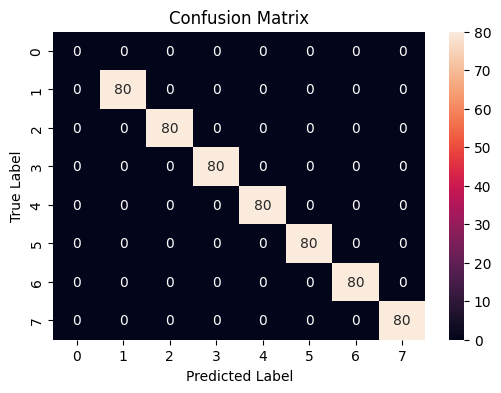

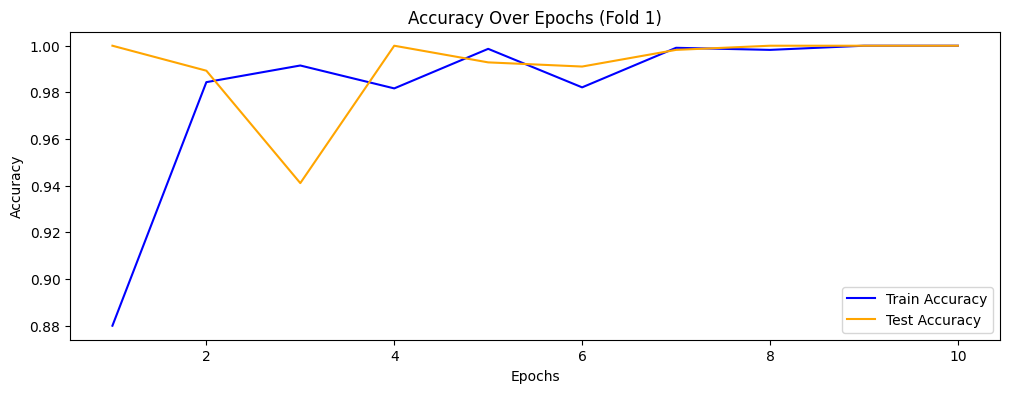

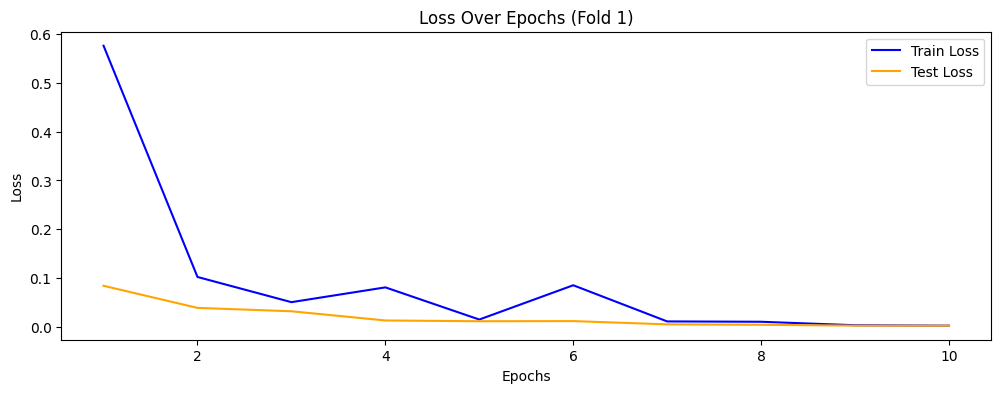


Fold 2/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 1 | Loss: 0.578 | Training Accuracy: 0.876 | Test Accuracy: 0.979


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 2 | Loss: 0.054 | Training Accuracy: 0.999 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 3 | Loss: 0.024 | Training Accuracy: 1.000 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 4 | Loss: 0.014 | Training Accuracy: 1.000 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 5 | Loss: 0.009 | Training Accuracy: 1.000 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 6 | Loss: 0.006 | Training Accuracy: 1.000 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 7 | Loss: 0.005 | Training Accuracy: 1.000 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 8 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 9 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 10 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 0.998
Precision: 0.998 | Recall: 0.998 | F1 Score: 0.998


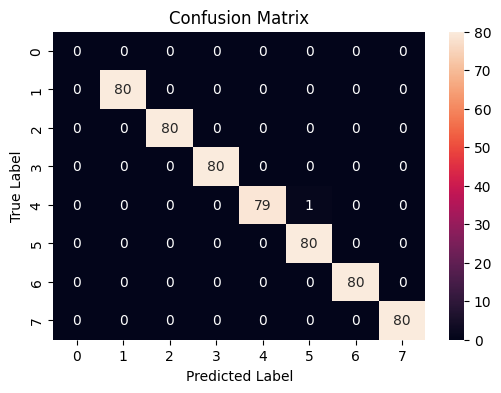

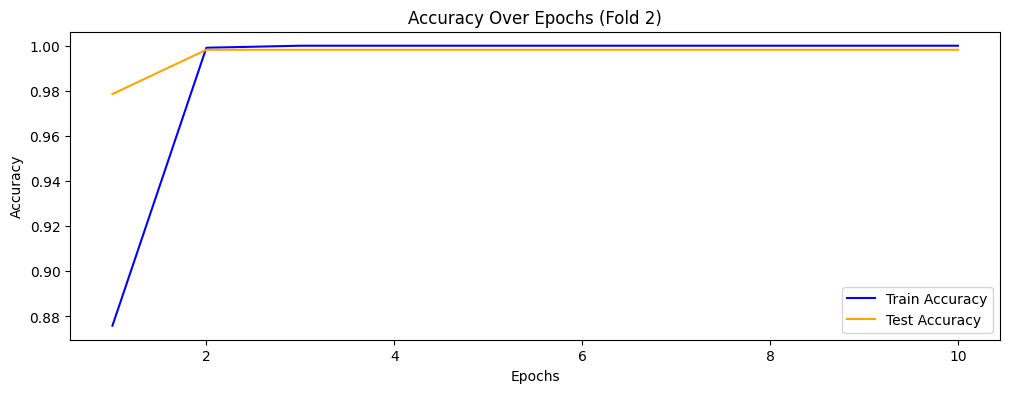

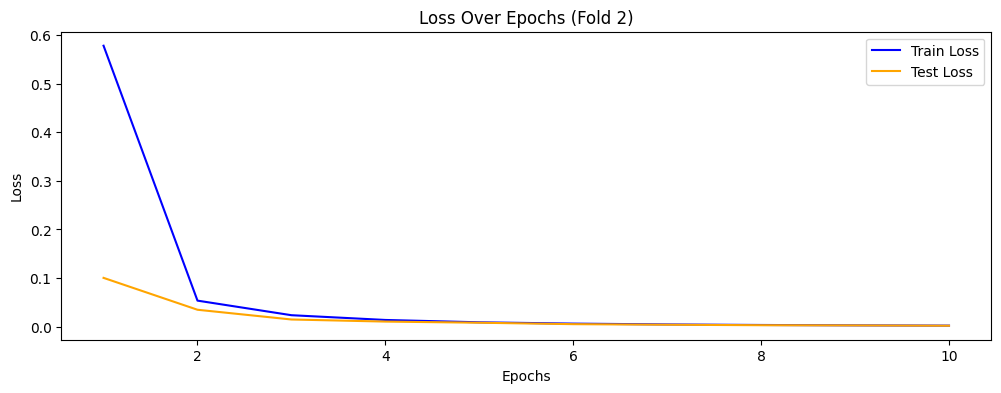


Fold 3/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 1 | Loss: 0.534 | Training Accuracy: 0.896 | Test Accuracy: 0.866


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 2 | Loss: 0.138 | Training Accuracy: 0.975 | Test Accuracy: 0.986


100%|██████████| 224/224 [01:29<00:00,  2.50it/s]


Epochs: 3 | Loss: 0.065 | Training Accuracy: 0.987 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.49it/s]


Epochs: 4 | Loss: 0.018 | Training Accuracy: 0.999 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 5 | Loss: 0.010 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 6 | Loss: 0.007 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.49it/s]


Epochs: 7 | Loss: 0.005 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 8 | Loss: 0.004 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 9 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 10 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 1.000
Precision: 1.000 | Recall: 1.000 | F1 Score: 1.000


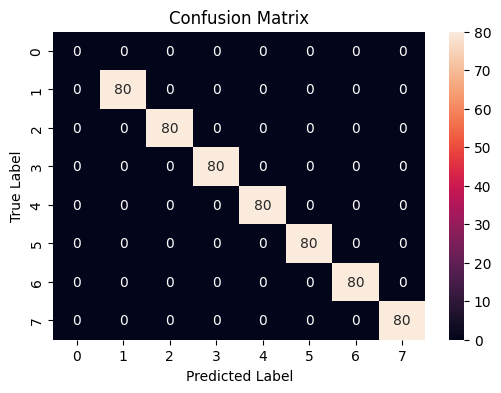

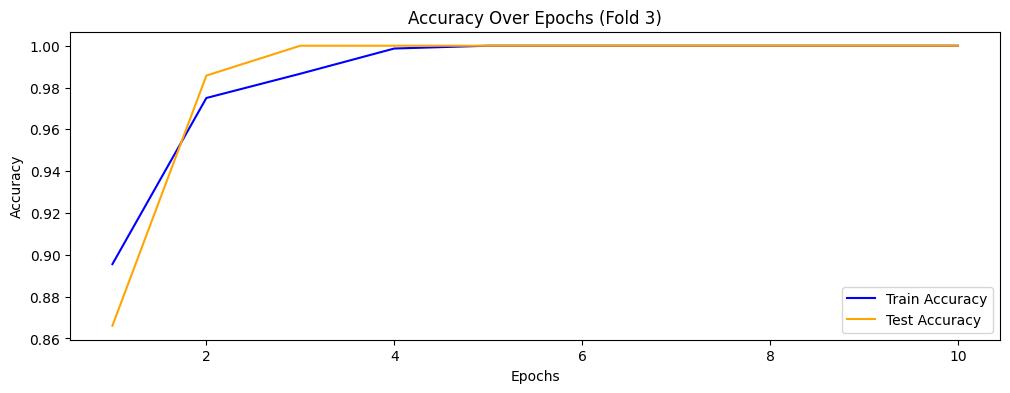

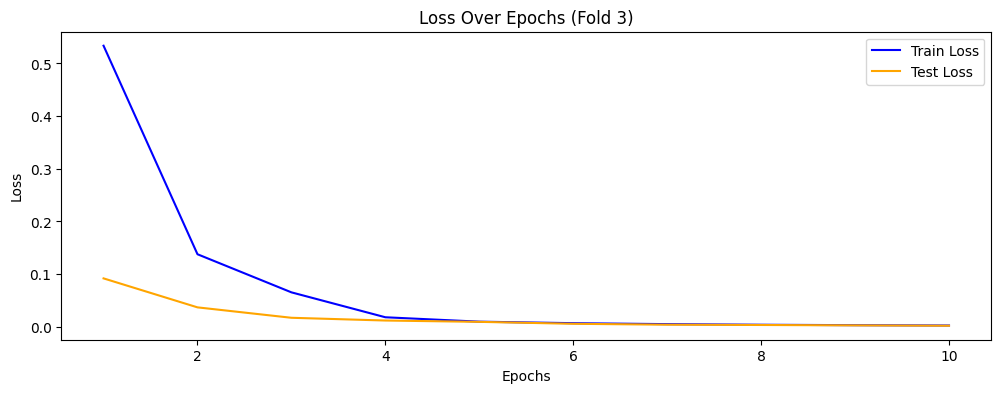


Fold 4/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 224/224 [01:30<00:00,  2.49it/s]


Epochs: 1 | Loss: 0.560 | Training Accuracy: 0.864 | Test Accuracy: 0.993


100%|██████████| 224/224 [01:29<00:00,  2.50it/s]


Epochs: 2 | Loss: 0.061 | Training Accuracy: 0.997 | Test Accuracy: 0.973


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 3 | Loss: 0.112 | Training Accuracy: 0.975 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 4 | Loss: 0.030 | Training Accuracy: 0.996 | Test Accuracy: 0.954


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 5 | Loss: 0.061 | Training Accuracy: 0.987 | Test Accuracy: 0.996


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 6 | Loss: 0.008 | Training Accuracy: 1.000 | Test Accuracy: 0.996


100%|██████████| 224/224 [01:30<00:00,  2.49it/s]


Epochs: 7 | Loss: 0.005 | Training Accuracy: 1.000 | Test Accuracy: 0.996


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 8 | Loss: 0.004 | Training Accuracy: 1.000 | Test Accuracy: 0.996


100%|██████████| 224/224 [01:30<00:00,  2.49it/s]


Epochs: 9 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.996


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 10 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 0.996
Precision: 0.996 | Recall: 0.996 | F1 Score: 0.996


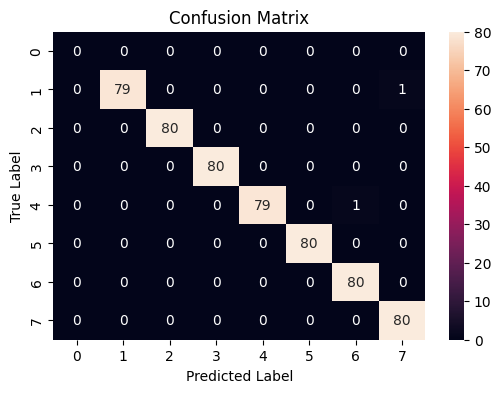

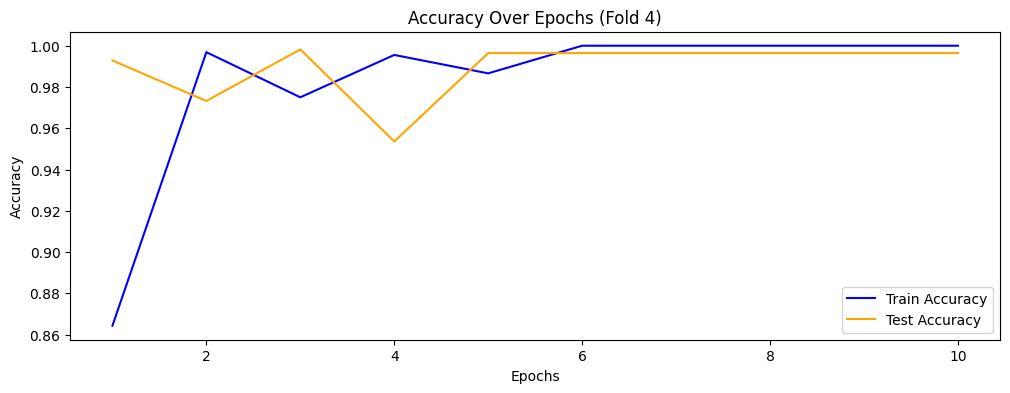

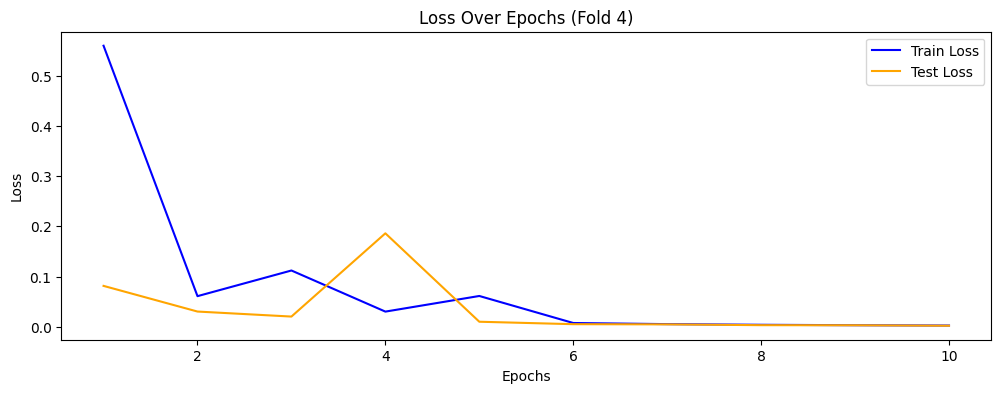


Fold 5/5


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTModel: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 1 | Loss: 0.548 | Training Accuracy: 0.883 | Test Accuracy: 0.973


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 2 | Loss: 0.057 | Training Accuracy: 0.999 | Test Accuracy: 0.998


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 3 | Loss: 0.023 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:29<00:00,  2.49it/s]


Epochs: 4 | Loss: 0.013 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 5 | Loss: 0.009 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 6 | Loss: 0.006 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 7 | Loss: 0.004 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.49it/s]


Epochs: 8 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 9 | Loss: 0.003 | Training Accuracy: 1.000 | Test Accuracy: 1.000


100%|██████████| 224/224 [01:30<00:00,  2.48it/s]


Epochs: 10 | Loss: 0.002 | Training Accuracy: 1.000 | Test Accuracy: 1.000
Precision: 1.000 | Recall: 1.000 | F1 Score: 1.000


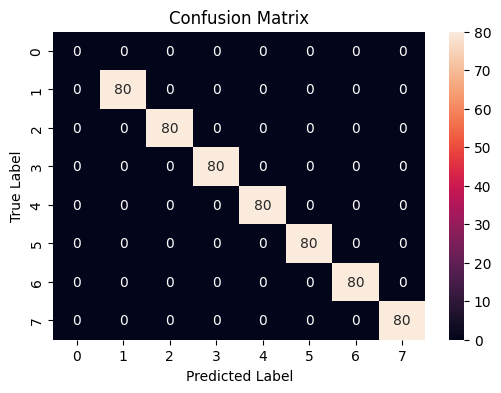

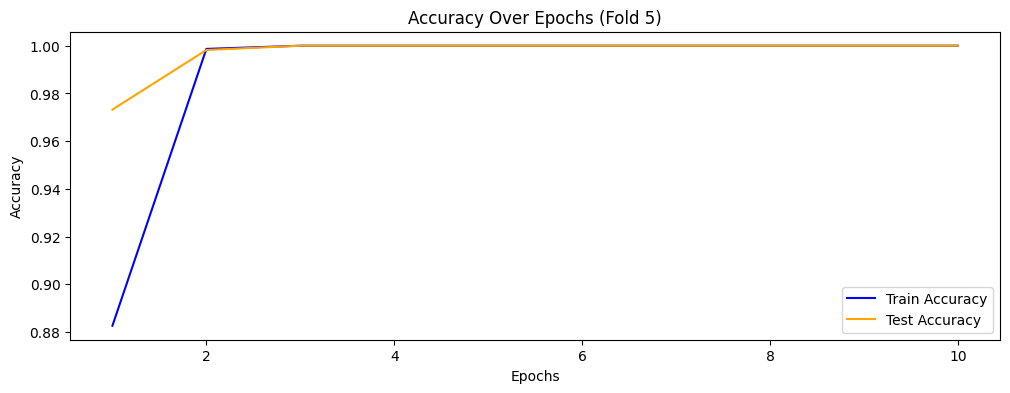

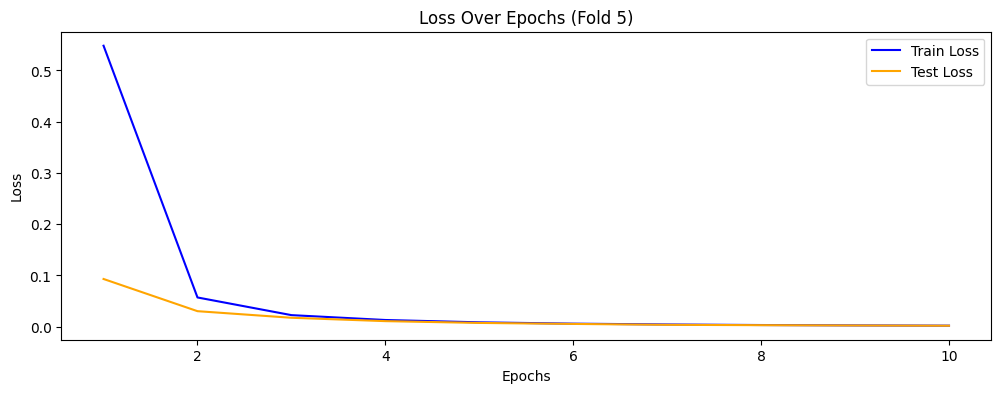

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already defined ViTConfig and ViTModel classes
class ViT(nn.Module):
    def __init__(self, config=ViTConfig(), num_labels=7, model_checkpoint='google/vit-base-patch16-224-in21k'):
        super(ViT, self).__init__()
        self.vit = ViTModel.from_pretrained(model_checkpoint, add_pooling_layer=False)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(config.hidden_size, num_labels)

    def forward(self, x):
        x = self.vit(x)['last_hidden_state']
        x = self.dropout(x)
        output = self.classifier(x[:, 0, :])
        return output

def plot_confusion_matrix(true_labels, predicted_labels, num_labels):
    cm = confusion_matrix(true_labels, predicted_labels, labels=list(range(num_labels)))
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="g", xticklabels=list(range(num_labels)), yticklabels=list(range(num_labels)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def print_classification_metrics(true_labels, predicted_labels):
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
    print(f'Precision: {precision:.3f} | Recall: {recall:.3f} | F1 Score: {f1:.3f}')

def model_train(train_dataset, test_dataset, epochs, learning_rate, batch_size, num_labels=8):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # Combine train and test datasets for cross-validation split
    all_data = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

    # Define cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_index, test_index) in enumerate(skf.split(all_data, [all_data[i][1] for i in range(len(all_data))])):
        print(f"\nFold {fold + 1}/{skf.n_splits}")

        # Split data into train and test sets for this fold
        train_subset = torch.utils.data.Subset(all_data, train_index)
        test_subset = torch.utils.data.Subset(all_data, test_index)

        # Load model, loss function, and optimizer
        model = ViT(num_labels=num_labels).to(device)
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Load batch image for training and testing
        train_dataloader = DataLoader(train_subset, num_workers=1, batch_size=batch_size, shuffle=True)
        test_dataloader = DataLoader(test_subset, num_workers=1, batch_size=batch_size)

        # Lists to store accuracy and loss values for plotting
        train_accuracies, test_accuracies = [], []
        train_losses, test_losses = [], []

        # Training loop
        for epoch in range(epochs):
            total_loss_train = 0.0
            total_correct_train = 0

            # Training
            model.train()
            for train_image, train_label in tqdm(train_dataloader):
                train_image, train_label = train_image.to(device), train_label.to(device)
                optimizer.zero_grad()
                output = model(train_image)
                loss = criterion(output, train_label)
                loss.backward()
                optimizer.step()
                total_loss_train += loss.item()
                total_correct_train += (output.argmax(1) == train_label).sum().item()

            train_accuracy = total_correct_train / len(train_subset)
            train_accuracies.append(train_accuracy)
            train_losses.append(total_loss_train / len(train_dataloader))

            # Evaluation on the test dataset
            total_correct_test = 0
            true_labels, predicted_labels = [], []

            model.eval()
            with torch.no_grad():
                for test_image, test_label in test_dataloader:
                    test_image, test_label = test_image.to(device), test_label.to(device)
                    output = model(test_image)
                    total_correct_test += (output.argmax(1) == test_label).sum().item()

                    true_labels.extend(test_label.cpu().numpy())
                    predicted_labels.extend(output.argmax(1).cpu().numpy())

            test_accuracy = total_correct_test / len(test_subset)
            test_accuracies.append(test_accuracy)
            test_losses.append(loss.item())

            print(f'Epochs: {epoch + 1} | Loss: {total_loss_train / len(train_dataloader):.3f} | '
                  f'Training Accuracy: {train_accuracy:.3f} | Test Accuracy: {test_accuracy:.3f}')

            # Print confusion matrix
        print_classification_metrics(true_labels, predicted_labels)
        plot_confusion_matrix(true_labels, predicted_labels, num_labels)
        # Plot accuracy and loss graphs
        plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, fold)


def plot_metrics(train_accuracies, test_accuracies, train_losses, test_losses, fold):
    epochs = range(1, len(train_accuracies) + 1)

    # Plot accuracies
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_accuracies, label=f'Train Accuracy', color='blue')
    plt.plot(epochs, test_accuracies, label=f'Test Accuracy', color='orange')
    plt.title(f'Accuracy Over Epochs (Fold {fold + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot losses
    plt.figure(figsize=(12, 4))
    plt.plot(epochs, train_losses, label=f'Train Loss', color='blue')
    plt.plot(epochs, test_losses, label=f'Test Loss', color='orange')
    plt.title(f'Loss Over Epochs (Fold {fold + 1})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Hyperparameters
EPOCHS = 10
LEARNING_RATE = 0.0001
BATCH_SIZE = 10

# Assuming you have already defined your ImageDataset class
# Convert the DataFrames to your custom datasets
train_df, test_df = train_test_split(TESS_df, test_size=0.4, random_state=42)
train_dataset = ImageDataset(train_df)
test_dataset = ImageDataset(test_df)

# Train the model with 5-fold cross-validation
trained_model = model_train(train_dataset, test_dataset, EPOCHS, LEARNING_RATE, BATCH_SIZE)